In [40]:
import os
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib.backends.backend_pdf import PdfPages

In [55]:
import copy
def smooth(x, alpha=0.02):
    _mean = copy.deepcopy(x)
    _std = np.zeros_like(x)
    for i in range(1, len(x)):
        _mean[i] = (1 - alpha) * _mean[i-1] + alpha * _mean[i]
        _std[i] = (1 - alpha) * _std[i-1] + alpha * np.square(x[i] - _mean[i])
    return _mean, np.sqrt(_std)

In [31]:
def rolling_window(array, window=1000):
    """
    apply a rolling window to a np.ndarray

    :param array: (np.ndarray) the input Array
    :param window: (int) length of the rolling window
    :return: (np.ndarray) rolling window on the input array
    """
    shape = array.shape[:-1] + (array.shape[-1] - window + 1, window)
    strides = array.strides + (array.strides[-1],)
    return np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)

In [32]:
def plot_one_line(y, color=None, label=None):
    y_mean, y_std = smooth(y[np.isfinite(y)])
    x = np.arange(len(y_mean)) * 100
    if y_std is not None:
        min_ = y_mean - y_std
        max_ = y_mean + y_std
        plt.fill_between(x, min_, max_, alpha=0.2, color=color)
    plt.plot(x, y_mean, label=label, color=color)

In [46]:
from stable_baselines.results_plotter import COLORS

def plot(*paths, **kargs):
    for (path, label, color) in paths:
        csv = pd.read_csv(os.path.join(path, 'progress.csv'))
#         pdf_path = os.path.join(path, 'ep_reward.pdf')
#         png_path = os.path.join(path, 'ep_reward.png')
        plot_one_line(csv[kargs['column']], color=color, label=label)
        print('plotting', os.path.join(path, 'progress.csv'))
    
    plt.title(kargs['title'])
    plt.xlabel(kargs['xlabel'])
    plt.legend()
    plt.grid(color='white')
    plt.savefig(os.path.join(path, 'reward.png'))
    plt.show()

plotting logs/BreakoutNoFrameskip-v4/baseline/progress.csv
plotting logs/BreakoutNoFrameskip-v4/3/progress.csv


KeyError: 2

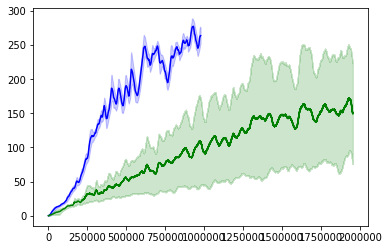

In [12]:
plot(
    ('logs/BreakoutNoFrameskip-v4/baseline/', 'Baseline', COLORS[0]),
    ('logs/BreakoutNoFrameskip-v4/3/', 'Individual', COLORS[1]), 
    ('logs/BreakoutNoFrameskip-v4/0/', 'Co-training', COLORS[2]),
    ('logs/BreakoutNoFrameskip-v4/1/', 'Co-training (alpha=1.0)', COLORS[3]),
    ('logs/BreakoutNoFrameskip-v4/2/', 'Co-training (alpha=0.5)', COLORS[4]),
    ('logs/BreakoutNoFrameskip-v4/4/', 'Co-training (alpha=0.2)', COLORS[5]),
    column='ep_reward_mean', xlabel='episodes', title='Mean Episode Reward'
)

In [ ]:
plot(
    ('logs/BreakoutNoFrameskip-v4/baseline/', 'Baseline', COLORS[0]),
    ('logs/BreakoutNoFrameskip-v4/3/', 'Individual', COLORS[1]), 
    ('logs/BreakoutNoFrameskip-v4/0/', 'Co-training', COLORS[2]),
    ('logs/BreakoutNoFrameskip-v4/1/', 'Co-training (alpha=1.0)', COLORS[3]),
    ('logs/BreakoutNoFrameskip-v4/2/', 'Co-training (alpha=0.5)', COLORS[4]),
    ('logs/BreakoutNoFrameskip-v4/4/', 'Co-training (alpha=0.2)', COLORS[5]),
    column='policy_loss', xlabel='episodes', title='Co-training loss')

In [34]:
plot(
    ('logs/PongNoFrameskip-v4/2000000_steps_peer0', 'alpha=0', COLORS[0]),
    ('logs/PongNoFrameskip-v4/2000000_steps_peer1', 'alpha=1', COLORS[1]),
    column='ep_reward_mean', xlabel='Episodes (x100)', title='Episode Reward'
)


FileNotFoundError: [Errno 2] File logs/PongNoFrameskip-v4/2000000_steps_peer0/progress.csv does not exist: 'logs/PongNoFrameskip-v4/2000000_steps_peer0/progress.csv'

plotting logs/PongNoFrameskip-v4/2000000_steps_peer0_cliped/progress.csv
plotting logs/PongNoFrameskip-v4/2000000_steps_peer1_cliped/progress.csv
plotting logs/PongNoFrameskip-v4/2000000_steps_peer0dot5_cliped/progress.csv
plotting logs/PongNoFrameskip-v4/2000000_steps_peer0dot2/progress.csv


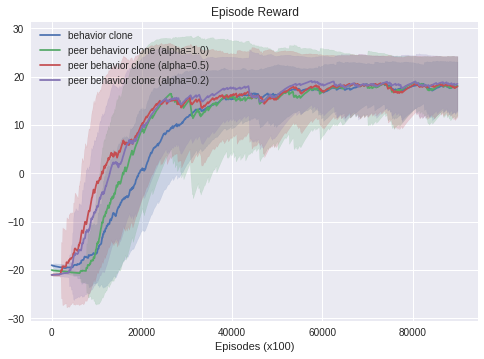

In [56]:
plot(
    ('logs/PongNoFrameskip-v4/2000000_steps_peer0_cliped/', 'behavior clone', 'C0'),
    ('logs/PongNoFrameskip-v4/2000000_steps_peer1_cliped/', 'peer behavior clone (alpha=1.0)', 'C1'),
    ('logs/PongNoFrameskip-v4/2000000_steps_peer0dot5_cliped/', 'peer behavior clone (alpha=0.5)', 'C2'),
    # ('logs/PongNoFrameskip-v4/2000000_steps_peer1dot5_cliped/', 'peer behavior clone (alpha=1.5)', 'C3'),
    ('logs/PongNoFrameskip-v4/2000000_steps_peer0dot2/', 'peer behavior clone (alpha=0.2)', 'C3'),
    column='ep_reward_mean', xlabel='Episodes (x100)', title='Episode Reward'
)

In [ ]:
plot(
    ('logs/PongNoFrameskip-v4/')
)

